In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import pandas as pd
import torch.optim as optim
import time
import ipywidgets as widgets
import pickle

# 導入dicom套件
from pydicom import dcmread
from pydicom.data import get_testdata_files

In [3]:
from utils.dataset import getAllDataPath, CustomImageDataset, show_image
from utils.unet import UNet, ResUnet, AttUnet

In [4]:
BATCH_SIZE = 8 # 8 for 256x256/ 16 for 128x128
NUM_LABELS = 1
WIDTH = 256
HEIGHT = 256 
MULTI_CHANNELS = False

### 取得image list
輸出: data_dic (字典)
- key: X_test, X_test, y_test, y_test

In [5]:
root = 'data/CHAOS_AIAdatasets/1_Domain_Gernalization_dataset/Test_Sets'
dic = {}
for a,b,c in os.walk(root, topdown=True):
    if len(c)>0: # 當前目錄內包含檔案
        if not a.__contains__('OutPhase'):
            dic[a] = c
dataset = {}
lis = ['CT', 'MRI']
for task in lis:
    class_lis = []
    for sub_folder in dic.keys():
        if task in sub_folder.split('/'):
            class_lis+=[sub_folder+'/'+filename for filename in dic[sub_folder]]
    dataset[task] = class_lis

dataset['CT_test'] = sorted([i for i in dataset['CT'] if 'dcm' in i])

dataset['MRI_DICOM_anon'] = sorted([i for i in dataset['MRI'] if 'dcm' in i])

dataset['MRI_T2SPIR_test'] = sorted([i for i in dataset['MRI_DICOM_anon'] if 'T2SPIR' in i])

In [6]:
MRI_test = list(dataset['MRI_T2SPIR_test'])
CT_test = list(dataset['CT_test'])


#### 使用albumentations進行資料擴增

In [7]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/
target_transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
])

### 建立DataLoader

In [8]:
# 建議同時間只有8個(256,256)的sample進行計算 (Total = BATCH_SIZE*MULTIPLE_BATCH)

dataset_test = CustomImageDataset(MRI_test, transform=target_transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

CT_dataset_test = CustomImageDataset(CT_test, transform=target_transform)
CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


torch.Size([1, 256, 256])


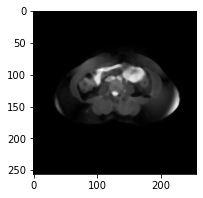

torch.Size([1, 256, 256])


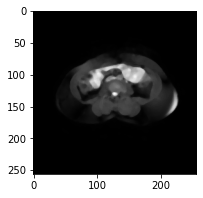

torch.Size([1, 256, 256])


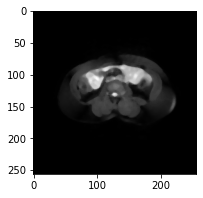

torch.Size([1, 256, 256])


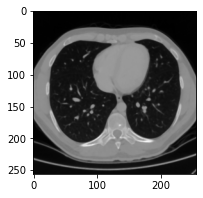

torch.Size([1, 256, 256])


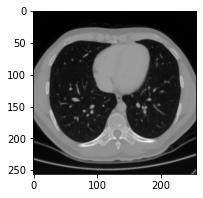

torch.Size([1, 256, 256])


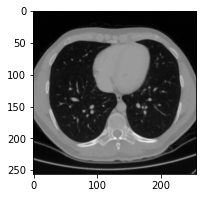

In [9]:
#@title [Colab Form] 測試不同的dataloader 
#@markdown 可能的選擇包括 'dataloader_test', 'dataloader_test', 'CT_dataloader_test'

def foo(): 

    dataloader = dataloader_test
    for dataloader in [dataloader_test, CT_dataloader_test]:
        dataloader = iter(dataloader) 
        image = dataloader.next()
        for idx, data in enumerate(image, 1):
            x = data
            print(x.shape)
            show_image(x[0].numpy())

            showPics = 3 #@param {type:"integer"}
            if idx==showPics: 
                break
foo()

## 測試模型

In [10]:
dic = dict(zip(
    ['dataloader_test', 'CT_dataloader_test'],
    [dataloader_test, CT_dataloader_test]
))

w = widgets.ToggleButtons(
    options=['CT_dataloader_test', 'dataloader_test', ],
    description='Testing DataSet',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

display(w)


ToggleButtons(description='Testing DataSet', options=('CT_dataloader_test', 'dataloader_test'), value='CT_data…

In [11]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [12]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: 
- https://pytorch.org/docs/stable/optim.html 
- Road Extraction by Deep Residual U-Net, 2017
- U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
- Attention U-Net: Learning Where to Look for the Pancreas, 2018
'''

device = 'cuda:0'
save_root = './data/save_weights/'

model = UNet
# model = ResUnet # suggest: only use it for single channel outputs, Sigmoid activation, Dice loss or focal loss
# model = AttUnet # better ResUnet 
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)
filepath = f'{save_root}model.bin'
model.load_state_dict(torch.load(filepath)) 

<All keys matched successfully>

In [14]:
ST_submission = []
for file_list, dataloader in zip([CT_test, MRI_test], [CT_dataloader_test, dataloader_test]):
    test_list = [['-'.join([str(i.split('/')[idx]) for idx in [-4,-3,-1]])] for i in file_list]
#     len(CT_test_list)

    dataloader = iter(dataloader)
    print(len(file_list))
    i = 0
    while 1:
        try:
            image= dataloader.next()
            image = image.to(device)

            outputs = model(image)
            
            # 調整一個合適的閾值
            thres = 0
            outputs[outputs<thres] = 0 
            outputs[outputs!=0] = 1
            outputs = outputs.long()
            outputs = outputs.detach().cpu()

            for out in outputs:
                test_list[i].append(mask2rle(out))

                i += 1
            print(i, end='\r')
        except StopIteration:
            print(i)
            print('complete')
            break
    ST_submission+=test_list
    assert i==len(test_list)
    
pd.DataFrame(ST_submission, columns=['filename', 'rle']).to_csv(f'{save_root}ST_submission.csv', index=False)

1173
1173
complete
160
160
complete
